### Create load road data

In [12]:
# pip install xlrd

In [13]:
# pip install openpyxl

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [15]:
# df_rd= pd.read_csv('BMMS/Roads_InfoAboutEachLRP.csv') 
# df_rd= pd.read_csv('RMMS/_overview.tcv', sep='\t', low_memory=False) # This file only shows the roadnr, name, length, and start and end place
df_rd = pd.read_csv('data/_roads.tsv', sep='\t', low_memory=False) # This file only shows the roadnr, name, length, and start and end place

# df_rd.describe()
display(df_rd)

,road,lrp1,lat1,lon1,lrp2,lat2,lon2,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 4035,Unnamed: 4036,Unnamed: 4037,Unnamed: 4038,Unnamed: 4039,Unnamed: 4040,Unnamed: 4041,Unnamed: 4042,Unnamed: 4043,Unnamed: 4044
0,N1,LRPS,23.706028,90.443333,LRPSa,23.702917,90.450417,LRPSb,23.702778,90.450472,...,92.29825,LRP466c,20.864667,92.298194,LRP467,20.862972,92.298083,LRPE,20.862917,92.298083
1,N101,LRPS,23.454139,91.212861,LRPSa,23.461889,91.212000,LRP001,23.462944,91.211806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N102,LRPS,23.478972,91.118194,LRPSa,23.481583,91.116777,LRPSb,23.486666,91.113361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N103,LRPS,23.957028,91.115528,LRP001,23.961917,91.113611,LRP001a,23.967666,91.111889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N104,LRPS,23.009667,91.399416,LRPSa,23.009278,91.395250,LRP001,23.009306,91.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,Z8910,LRPS,22.674722,90.408889,LRPSa,22.675916,90.412556,LRP001,22.675583,90.417166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,Z8913,LRPS,22.396083,90.688666,LRPSa,22.393027,90.688944,LRPSb,22.392666,90.689083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,Z8915,LRPS,22.589389,90.619472,LRP001,22.589694,90.623360,LRP001a,22.590027,90.631360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
883,Z8916,LRPS,22.625499,90.661722,LRPSa,22.623888,90.664167,LRP001,22.620305,90.668999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Import the bridge data
df_brd = pd.read_excel('data\BMMS_overview.xlsx')
# df_brd

<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:2: SyntaxWarning: invalid escape sequence '\B'
C:\Users\groen\AppData\Local\Temp\ipykernel_15096\2792103768.py:2: SyntaxWarning: invalid escape sequence '\B'
  df_brd = pd.read_excel('data\BMMS_overview.xlsx')


In [17]:
first_row = df_rd.iloc[0]

# Select every third value for 'LAT' and every third +1 value for 'LON'
df_rd_N1 = pd.DataFrame({
    'LRP': first_row.iloc[1::3].values,   # Every third value
    'LAT': first_row.iloc[2::3].values,   # Every third value
    'LON': first_row.iloc[3::3].values   # Every third +1 value
})

df_rd_N1['LAT'] = df_rd_N1['LAT'].astype(float)
df_rd_N1['LON'] = df_rd_N1['LON'].astype(float)

df_rd_N1

,LRP,LAT,LON
0,LRPS,23.706028,90.443333
1,LRPSa,23.702917,90.450417
2,LRPSb,23.702778,90.450472
3,LRP001,23.702139,90.451972
4,LRP002,23.697889,90.460583
...,...,...,...
1343,LRP466a,20.868860,92.298222
1344,LRP466b,20.865028,92.298250
1345,LRP466c,20.864667,92.298194
1346,LRP467,20.862972,92.298083


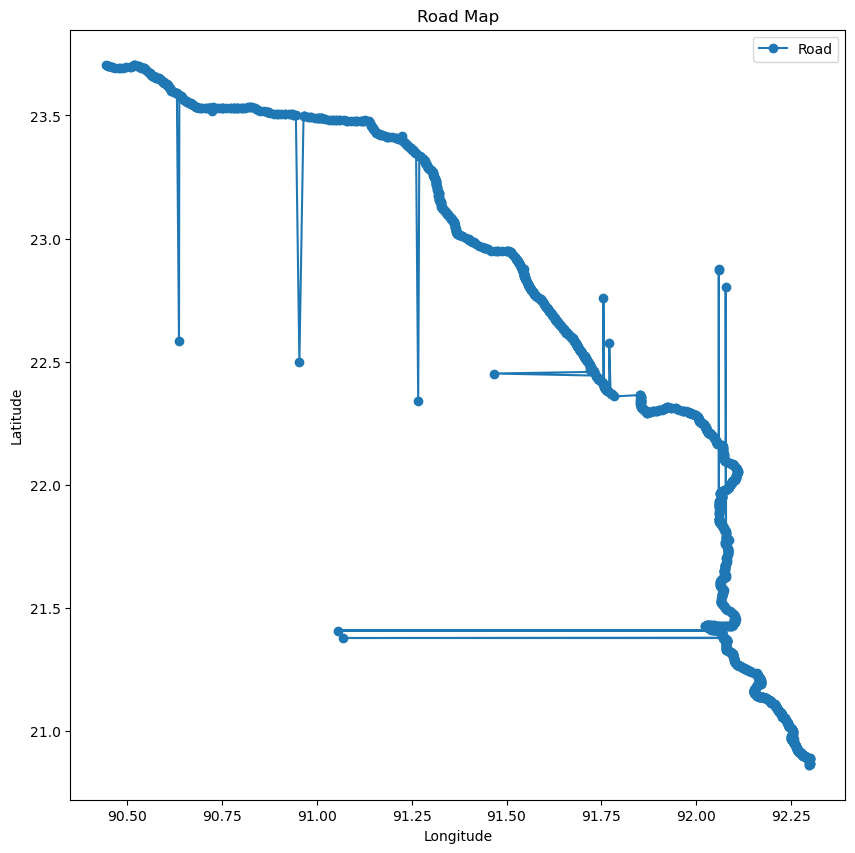

In [18]:
# Create plot function

def plot_map(df_rd):
    plt.figure(figsize=(10, 10))
    plt.plot(df_rd['LON'], df_rd['LAT'], 'o-', label='Road')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Road Map')
    plt.legend()
    plt.show()

plot_map(df_rd_N1)

In [19]:
df_rd_N1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LRP     1348 non-null   object 
 1   LAT     1348 non-null   float64
 2   LON     1348 non-null   float64
dtypes: float64(2), object(1)
memory usage: 31.7+ KB


In [20]:
# Calculate the distance between two points

def calc_lrp_distance(df_rd_lrp):
    df_lrp_before = df_rd_lrp.shift()  # The LRP before
    lrp_dist = np.sqrt((df_lrp_before["LAT"] - df_rd_lrp["LAT"])**2 + (df_lrp_before["LON"] - df_rd_lrp["LON"])**2)
    
    return lrp_dist

lrp_dist = calc_lrp_distance(df_rd_N1)
print(lrp_dist)

0            NaN
1       0.007737
2       0.000150
3       0.001630
4       0.009603
          ...   
1343    0.000425
1344    0.003833
1345    0.000365
1346    0.001698
1347    0.000056
Length: 1348, dtype: float64


In [21]:
lrp_dist.describe()

count    1347.000000
mean        0.014844
std         0.102921
min         0.000000
25%         0.000878
50%         0.002278
75%         0.004731
max         1.008723
dtype: float64

### Which LRPs are off the road
For the single (individual) LRPs off the road: one is off the road then the next one is on the road agaiin! But both edges are longer than 'usual'.

For more than one successive LRPs off the road, see `get_lrps_off_rd_2`

In [22]:
def get_lrps_off_rd(lrp_dist):
    threshold = lrp_dist.quantile(0.8) * 20  # 80% of the LRP distances are below this value

    # both edges before and after the LRP are long
    lrp_off_rd = lrp_dist.loc[(lrp_dist > threshold) & (lrp_dist.shift(-1) > threshold)]
    return lrp_off_rd

lrp_off_rd = get_lrps_off_rd(lrp_dist)

print('count:' + str(lrp_off_rd.count()))
print(lrp_off_rd)
print(df_rd_N1.loc[lrp_off_rd.index])

count:9
69      1.005876
154     1.002543
233     1.007321
538     0.263948
553     0.350000
567     0.199861
817     0.999889
993     0.998751
1016    0.999973
dtype: float64
          LRP        LAT        LON
69    LRP027a  22.583750  90.636944
154    LRP065  22.499527  90.954167
233    LRP108  22.339055  91.267222
538    LRP225  22.451861  91.466611
553   LRP230c  22.758417  91.755139
567   LRP234b  22.576333  91.770527
817    LRP332  22.802917  92.077277
993   LRP391a  21.407972  91.056000
1016  LRP395b  21.377583  91.070360


#### Pull back the single LRPs that were found

[69, 154, 233, 538, 553, 567, 817, 993, 1016]


C:\Users\groen\AppData\Local\Temp\ipykernel_15096\3274260422.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_rd.LAT.loc[lrp_off_rd.index] = 0.5 * (df_rd.LAT.shift().loc[lrp_off_rd.index] + df_rd.LAT.shift(-1).loc[lrp_off_rd.index])
C:

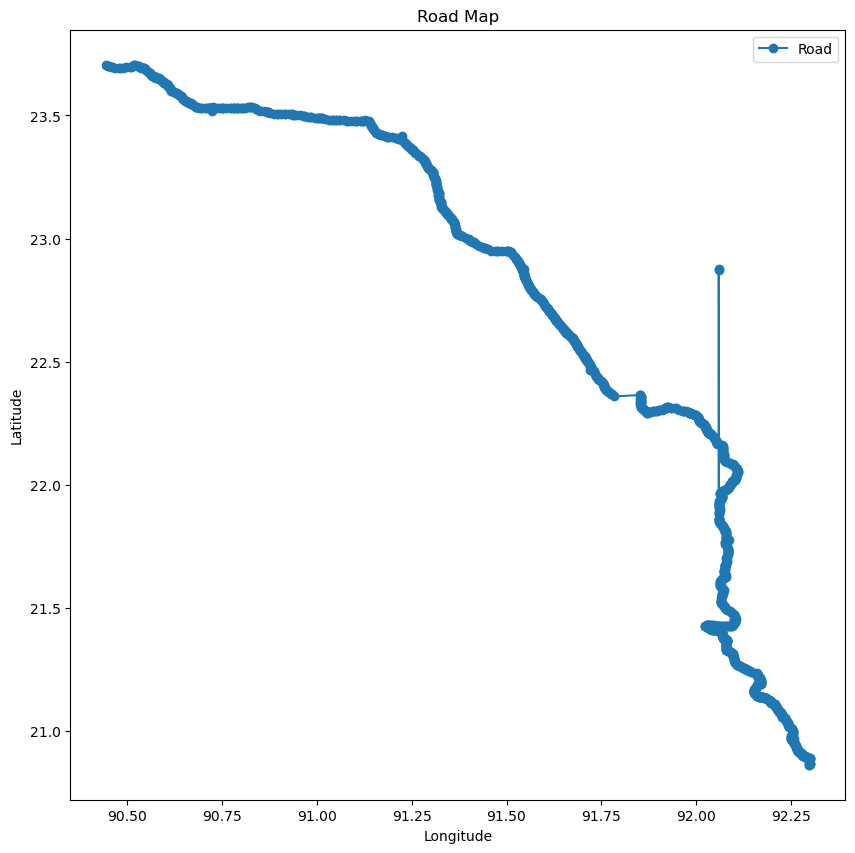

In [23]:
def correct_lrps_off_rd(df_rd, lrp_off_rd):

    df_rd.LAT.loc[lrp_off_rd.index] = 0.5 * (df_rd.LAT.shift().loc[lrp_off_rd.index] + df_rd.LAT.shift(-1).loc[lrp_off_rd.index])
    df_rd.LON.loc[lrp_off_rd.index] = 0.5 * (df_rd.LON.shift().loc[lrp_off_rd.index] + df_rd.LON.shift(-1).loc[lrp_off_rd.index])

    return df_rd # vanaf hier niet meegeschreven voor deze functie


df_rd_new = correct_lrps_off_rd(df_rd_N1.copy(), lrp_off_rd)

lrp_changed_index = lrp_off_rd.index.tolist()
print(lrp_changed_index)

# plot_rd(rd_name, df_rd)
# prot_rd(rd_name, df_rd_new)

plot_map(df_rd_new)

### Now for all rows

In [29]:
import numpy as np
import pandas as pd

# Sample DataFrame (Replace this with actual df_rd)
# df_rd = pd.DataFrame([
#     [1, 100, 10, 20, 101, 40, 50, 102, 70, 80],  # Road 1
#     [2, 200, 15, 25, 201, 45, 55, 202, 75, 85],  # Road 2
# ], columns=[f"col_{i}" for i in range(10)])  # Example column names

# Function to extract LRP, LAT, and LON for each road
def extract_lrps(df_rd):
    all_roads = []
    
    for i in range(len(df_rd)):  # Loop through all rows (roads)
        row = df_rd.iloc[i]

        # Extract every third value for LRP, LAT, and LON
        df_rd_N1 = pd.DataFrame({
            'road': row.iloc[0],
            'LRP': row.iloc[1::3].values,
            'LAT': row.iloc[2::3].astype(float).values,
            'LON': row.iloc[3::3].astype(float).values
        })
        
        df_rd_N1['Road_ID'] = i  # Add a road identifier
        all_roads.append(df_rd_N1)  # Append results

    return pd.concat(all_roads, ignore_index=True)  # Merge all road data

df_rd_N1 = extract_lrps(df_rd)
print(df_rd_N1)

# Function to calculate LRP distances for all roads
def calc_lrp_distance(df_rd_lrp):
    df_rd_lrp["LRP_Dist"] = df_rd_lrp.groupby("Road_ID").apply(
        lambda group: np.sqrt(
            (group["LAT"].shift() - group["LAT"])**2 + 
            (group["LON"].shift() - group["LON"])**2
        )
    ).reset_index(level=0, drop=True)
    
    return df_rd_lrp

df_rd_N1 = calc_lrp_distance(df_rd_N1)
print(df_rd_N1)

# Identify LRPs that are off-road
def get_lrps_off_rd(lrp_dist):
    threshold = lrp_dist.groupby("Road_ID")["LRP_Dist"].transform(lambda x: x.quantile(0.8) * 20)
    lrp_off_rd = lrp_dist.loc[(lrp_dist["LRP_Dist"] > threshold) & (lrp_dist["LRP_Dist"].shift(-1) > threshold)]
    return lrp_off_rd

lrp_off_rd = get_lrps_off_rd(df_rd_N1)
print("Off-road LRPs:", lrp_off_rd)

# Correct LRPs that are off-road
def correct_lrps_off_rd(df_rd, lrp_off_rd):
    for index in lrp_off_rd.index:
        df_rd.at[index, "LAT"] = 0.5 * (df_rd.at[index - 1, "LAT"] + df_rd.at[index + 1, "LAT"])
        df_rd.at[index, "LON"] = 0.5 * (df_rd.at[index - 1, "LON"] + df_rd.at[index + 1, "LON"])
    
    return df_rd

df_rd_new = correct_lrps_off_rd(df_rd_N1.copy(), lrp_off_rd)
print("Corrected LRPs:", df_rd_new)

# Visualizing the updated map

          road     LRP        LAT        LON  Road_ID
0           N1    LRPS  23.706028  90.443333        0
1           N1   LRPSa  23.702917  90.450417        0
2           N1   LRPSb  23.702778  90.450472        0
3           N1  LRP001  23.702139  90.451972        0
4           N1  LRP002  23.697889  90.460583        0
...        ...     ...        ...        ...      ...
1192975  Z8943     NaN        NaN        NaN      884
1192976  Z8943     NaN        NaN        NaN      884
1192977  Z8943     NaN        NaN        NaN      884
1192978  Z8943     NaN        NaN        NaN      884
1192979  Z8943     NaN        NaN        NaN      884

[1192980 rows x 5 columns]


C:\Users\groen\AppData\Local\Temp\ipykernel_15096\1801186999.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rd_lrp["LRP_Dist"] = df_rd_lrp.groupby("Road_ID").apply(


          road     LRP        LAT        LON  Road_ID  LRP_Dist
0           N1    LRPS  23.706028  90.443333        0       NaN
1           N1   LRPSa  23.702917  90.450417        0  0.007737
2           N1   LRPSb  23.702778  90.450472        0  0.000150
3           N1  LRP001  23.702139  90.451972        0  0.001630
4           N1  LRP002  23.697889  90.460583        0  0.009603
...        ...     ...        ...        ...      ...       ...
1192975  Z8943     NaN        NaN        NaN      884       NaN
1192976  Z8943     NaN        NaN        NaN      884       NaN
1192977  Z8943     NaN        NaN        NaN      884       NaN
1192978  Z8943     NaN        NaN        NaN      884       NaN
1192979  Z8943     NaN        NaN        NaN      884       NaN

[1192980 rows x 6 columns]
Off-road LRPs:           road      LRP        LAT        LON  Road_ID  LRP_Dist
69          N1  LRP027a  22.583750  90.636944        0  1.005876
154         N1   LRP065  22.499527  90.954167        0  1.0

In [30]:
df_rd_new.describe()

,LAT,LON,Road_ID,LRP_Dist
count,52210.000000,52210.000000,1.192980e+06,51333.000000
mean,23.823421,90.275009,4.420000e+02,0.016744
std,1.138911,1.085626,2.554774e+02,0.210834
min,20.790777,88.129722,0.000000e+00,0.000000
25%,22.930187,89.361653,2.210000e+02,0.001083
50%,23.823513,90.170444,4.420000e+02,0.002959
75%,24.715701,91.086215,6.630000e+02,0.005957
max,26.633222,92.968666,8.840000e+02,20.001111


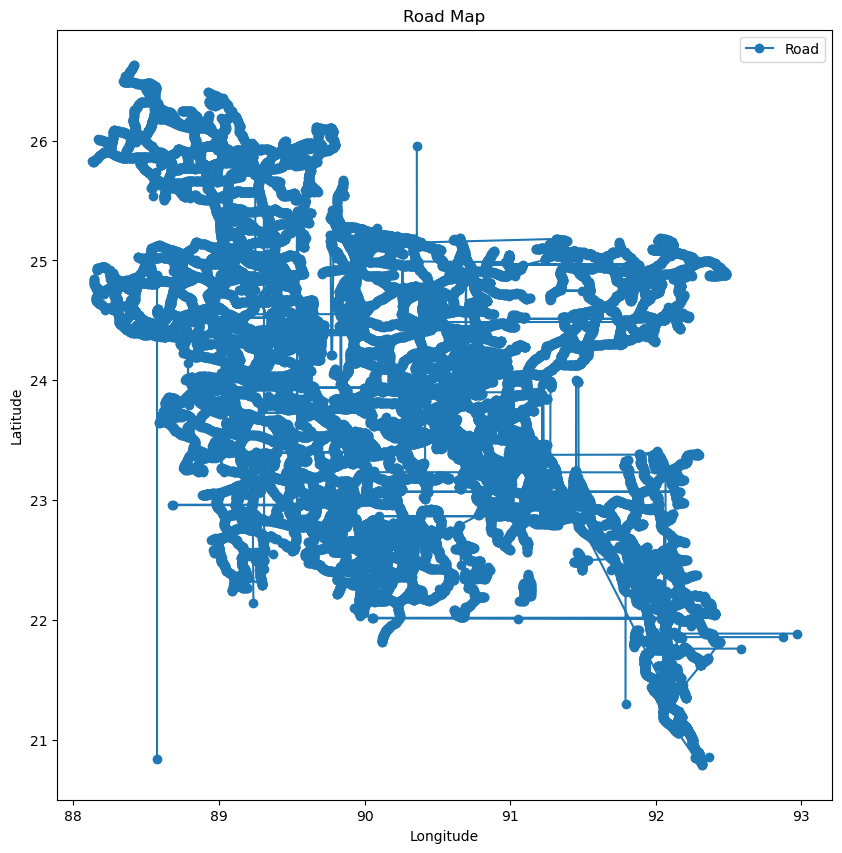

In [27]:
plot_map(df_rd_new)  # Assuming you have a function `plot_map()`


### For multiple outliers after eachother
